In [1]:
#### TASK 3 IS IN THIS NOTEBOOK
# Needs to pip install opencv-python and pillow
# The final graphs plus rendering the window were code from stack overflow, so the % of code from the web should be 30-35%
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from matplotlib import style
import warnings # Remove some warnings that aren't relevant

NEW_DATA = False # set true to generate new data

class ImageDetector():
    MAX_IMAGE_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    IDENTIFIERS = {CATS: 0, DOGS: 1}
    data = []

    cCount = 0
    dCount = 0

    def make_data(self):
        for identifier in self.IDENTIFIERS:
            print(identifier)
            for f in tqdm(os.listdir(identifier)):
                if "jpg" in f:
                    try:
                        path = os.path.join(identifier, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.MAX_IMAGE_SIZE, self.MAX_IMAGE_SIZE))
                        self.data.append([np.array(img), np.eye(2)[self.IDENTIFIERS[identifier]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.IDENTIFIERS[identifier]])

                        if identifier == self.CATS:
                            self.cCount += 1
                        elif identifier == self.DOGS:
                            self.dCount += 1

                    except Exception as e:
                        pass
                        #print(identifier, f, str(e))

        np.random.shuffle(self.data)
        np.save("data.npy", self.data)
        print('Cats:',imageDetect.cCount)
        print('Dogs:',imageDetect.dCount)


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



if torch.cuda.is_available():
    device = torch.device("cuda:0")  # Render on the GPU, but sadly it only works on NVIDIA graphic cards (not mine)
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")




neuralNetwork = NeuralNetwork().to(device)

if NEW_DATA:
    imageDetect = ImageDetector()
    imageDetect.make_data()

data = np.load("data.npy", allow_pickle=True)
print(len(data))

optimizer = optim.Adam(neuralNetwork.parameters(), lr=0.001)
fail_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in data])

VALUE_PCT = 0.1
value_size = int(len(X)*VALUE_PCT)
print(value_size)

improve_X = X[:-value_size]
improve_y = y[:-value_size]

check_X = X[-value_size:]
check_Y = y[-value_size:]

print(len(improve_X))
print(len(check_X))

def foward_pass_values(X, y, improve=False):

    if improve:
        neuralNetwork.zero_grad()
    outputs = neuralNetwork(X)
    equals  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    accuracy = equals.count(True)/len(equals)
    fail = fail_function(outputs, y)

    if improve:
        fail.backward()
        optimizer.step()

    return accuracy, fail

def test_values(size=32):
    X, y = check_X[:size], check_Y[:size]
    value_accuracy, value_fail = foward_pass_values(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return value_accuracy, value_fail

value_accuracy, value_fail = test_values(size=100)
print(value_accuracy, value_fail)

MODEL = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
neuralNetwork = NeuralNetwork().to(device)
optimizer = optim.Adam(neuralNetwork.parameters(), lr=0.001)
fail_function = nn.MSELoss()

print(MODEL)
def improve(neuralNetwork):
    BATCH_SIZE = 100
    EPOCHS = 20

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(improve_X), BATCH_SIZE)):
                batch_X = improve_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = improve_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                accuracy, fail = foward_pass_values(batch_X, batch_y, improve=True)

                #print(f"Acc: {round(float(accuracy),2)}  Loss: {round(float(fail),4)}")
                #f.write(f"{MODEL},{round(time.time(),3)},improve,{round(float(accuracy),2)},{round(float(fail),4)}\n")
                # just to show the above working, and then get out:
                if i % 50 == 0:
                    value_accuracy, value_fail = test_values(size=100)
                    f.write(f"{MODEL},{round(time.time(),3)},{round(float(accuracy),2)},{round(float(fail), 4)},{round(float(value_accuracy),2)},{round(float(value_fail),4)},{epoch}\n")
improve(neuralNetwork)

def test_values(neuralNetwork):
    precise = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(check_X))):
            real_class = torch.argmax(check_Y[i]).to(device)
            neuralNetwork_out = neuralNetwork(check_X[i].view(-1, 1, 50, 50).to(device))[0]

            predicted_class = torch.argmax(neuralNetwork_out)
            if predicted_class == real_class:
                precise += 1
            total += 1
    print("Precision:", round(precise/total,3))

Running on the CPU
24946
2494
22452
2494
0.58 tensor(0.2493, grad_fn=<MseLossBackward>)
model-1618153748


100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [01:02<00:00,  3.62it/s]


In [2]:
def batch_test_values(neuralNetwork):
    BATCH_SIZE = 100
    precise = 0
    total = 0
    with torch.no_grad():
        #np.random.shuffle(check_X)
        #np.random.shuffle(check_Y)

        batch_X = check_X[:BATCH_SIZE].view(-1,1,50,50)
        batch_y = check_Y[:BATCH_SIZE]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        neuralNetwork.zero_grad()
        outputs = neuralNetwork(batch_X)

        equals  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
        accuracy = equals.count(True)/len(equals)

        print("Test Precision:", round(accuracy, 3))


    batch_test_values(neuralNetwork)

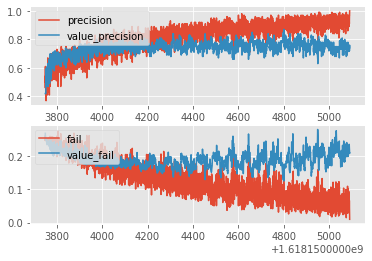

In [3]:
style.use("ggplot")

model = MODEL #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL if you're in a notebook still.


def create_precision_fail_graph(model):
    contents = open("model.log", "r").read().split("\n")

    times = []
    precisions = []
    failes = []

    value_precisions = []
    value_failes = []

    for c in contents:
        if model in c:
            name, timestamp, precision, fail, value_precision, value_fail, epoch = c.split(",")

            times.append(float(timestamp))
            precisions.append(float(precision))
            failes.append(float(fail))

            value_precisions.append(float(value_precision))
            value_failes.append(float(value_fail))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, precisions, label="precision")
    ax1.plot(times, value_precisions, label="value_precision")
    ax1.legend(loc=2)
    ax2.plot(times,failes, label="fail")
    ax2.plot(times,value_failes, label="value_fail")
    ax2.legend(loc=2)
    plt.show()

create_precision_fail_graph(model)